In [3]:
import numpy as np
import pandas as pd
from dotenv import load_dotenv
import os
load_dotenv()


True

In [4]:
from pydantic import BaseModel, Field

In [5]:
class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized web search.")
    justification: str = Field(
        None, justification="Why this query is relevant to the user's request."
    )

C:\Users\mrsim\AppData\Local\Temp\ipykernel_23796\422989119.py:3: PydanticDeprecatedSince20: Using extra keyword arguments on `Field` is deprecated and will be removed. Use `json_schema_extra` instead. (Extra keys: 'justification'). Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  justification: str = Field(


In [6]:
from langchain_google_genai import ChatGoogleGenerativeAI  # <--- Change this import

# Instantiate Chat Model
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash-lite",
    google_api_key=os.getenv("GOOGLE_AI_API_KEY"),
    temperature=0
)

# Now checking for structured output
structured_llm = llm.with_structured_output(SearchQuery)
output = structured_llm.invoke("How does Calcium CT score relate to high cholesterol?")
print(output)

search_query='calcium score high cholesterol relationship' justification='The user is asking about the relationship between Calcium CT score and high cholesterol. A direct search query combining these terms will likely yield relevant information explaining any potential links or correlations.'


In [7]:
# Define a tool
def multiply(a: int, b: int) -> int:
    return a * b

# Augment the LLM with tools
llm_with_tools = llm.bind_tools([multiply])

# Invoke the LLM with input that triggers the tool call
msg = llm_with_tools.invoke("What is 2 times 3?")

# Get the tool call
msg.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': '5edada7f-04ed-49d2-9607-43c8e4b62c3d',
  'type': 'tool_call'}]

In [8]:
from typing_extensions import TypedDict

# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str

In [9]:
# Nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}

def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}


def polish_joke(state: State):
    """Third LLM call for final polish"""

    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}

# Conditional edge function to check if the joke has a punchline
def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Pass"
    return "Fail"

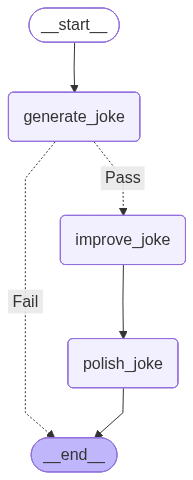

In [10]:

from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Pass": "improve_joke", "Fail": END}
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

In [11]:
# Graph state
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str

In [12]:
# Nodes
def call_llm_1(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def call_llm_2(state: State):
    """Second LLM call to generate story"""

    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story": msg.content}


def call_llm_3(state: State):
    """Third LLM call to generate poem"""

    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}


def aggregator(state: State):
    """Combine the joke and story into a single output"""

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}


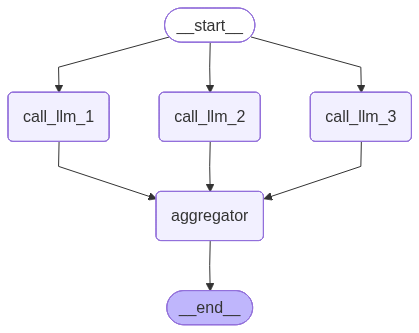

In [13]:

# Build workflow
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

# Add edges to connect nodes
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)
parallel_workflow = parallel_builder.compile()

# Show workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

In [14]:
from typing_extensions import Literal

# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(None, description="The next step in the routing process")

# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)

In [15]:
# State
class State(TypedDict):
    input: str
    decision: str
    output: str

In [16]:
from langchain_core.messages import HumanMessage, SystemMessage

# Nodes
def llm_call_1(state: State):
    """Write a story"""

    print("Write a story")
    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_2(state: State):
    """Write a joke"""

    print("Write a joke")
    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_3(state: State):
    """Write a poem"""

    print("Write a poem")
    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke([SystemMessage(content="Route the input to story, joke, or poem based on the user's request."), HumanMessage(content=state["input"])])

    return {"decision": decision.step}

# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"

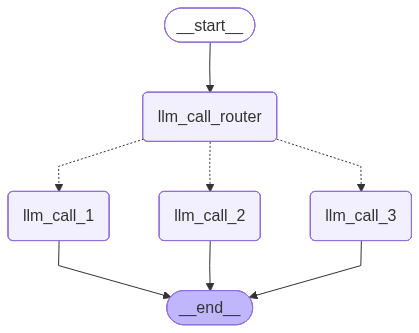

In [17]:

# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

In [18]:
state = router_workflow.invoke({"input": "Write me a joke about cats"})
print(state["output"])

Write a joke
Why did the cat sit on the computer?

Because it wanted to keep an eye on the **mouse**!


In [48]:
from langchain_core.tools import Tool
from langchain_google_community import GoogleSearchAPIWrapper

search = GoogleSearchAPIWrapper(    
    google_api_key=os.getenv('GOOGLE_SEARCH_API_KEY'),
    google_cse_id=os.getenv('GOOGLE_CSE_ID'),
    k=5)

tool = Tool(
    name="google_search",
    description="Search Google for recent results.",
    func=search.run,
)

In [52]:
query_ = "find all four quarter earnings call transcript of the apple in 2025"
search.results(query_, 5)

[{'title': 'Investor Relations - Apple',
  'link': 'https://investor.apple.com/investor-relations/default.aspx',
  'snippet': 'Apple announced results and business updates for the quarter ended September 27, 2025. ... More ways to shop: Visit an Apple Store, call 1-800-MY-APPLE, or find a\xa0...'},
 {'title': 'Apple reports fourth quarter results - Apple',
  'link': 'https://www.apple.com/newsroom/2025/10/apple-reports-fourth-quarter-results/',
  'snippet': 'Oct 30, 2025 ... “Today, Apple is very proud to report a September quarter revenue record of $102.5 billion, including a September quarter revenue record for\xa0...'},
 {'title': 'Apple Inc. (AAPL) Q4 FY2025 earnings call transcript',
  'link': 'https://finance.yahoo.com/quote/AAPL/earnings/AAPL-Q4-2025-earnings_call-369370.html/',
  'snippet': "Oct 30, 2025 ... You can find a reconciliation of these measures in our fourth quarter earnings release, which is available on our Investor Relations website. I'\xa0..."},
 {'title': 'Apple

In [47]:
def get_search(query:str="", k:int=1): # get the top-k resources with google
    search = GoogleSearchAPIWrapper(k=k)
    def search_results(query):
        return search.results(query, k)
    tool = Tool(
        name="Google Search Snippets",
        description="Search Google for recent results.",
        func=search_results,
    )
    ref_text = tool.run(query)
    if 'Result' not in ref_text[0].keys():
        return ref_text
    else:
        return None